In [1]:
#probably more things than I need to import
#some carried over from scraping

from bs4 import BeautifulSoup
import requests
import time, os
import pandas as pd
from IPython.core.display import display, HTML
import re
from re import sub
from decimal import Decimal
from selenium import webdriver
from selenium.webdriver.support.ui import Select
from iso3166 import countries
import numpy as np
from sklearn.metrics import r2_score
from sklearn.model_selection import KFold
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, PolynomialFeatures
from sklearn.model_selection import cross_val_score
from sklearn.linear_model import LinearRegression, Lasso, LassoCV, Ridge, RidgeCV
import seaborn as sns
%matplotlib inline
import random
from sklearn.pipeline import Pipeline
from sklearn.linear_model import lars_path
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error, mean_absolute_error


In [2]:
df1 = pd.read_csv("Data_from_top_1000")
df2 = pd.read_csv("Second_DF")

In [3]:
df = pd.concat([df1, df2])

In [4]:
df = df.drop_duplicates(subset = "Unnamed: 0")

In [5]:
df = df.dropna()

In [6]:
mpaa_list = list(df["MPAA"])

In [7]:
mpaa_string_list = []
for x in mpaa_list:
    x = x.replace(">", " ").replace("<"," ").split(" ")[2]
    mpaa_string_list.append(x)

In [8]:
df["Movie Rating"] = mpaa_string_list

In [9]:
df = df.drop(columns = "MPAA")

In [10]:
df = df.rename(columns={"Unnamed: 0": "Movie Titles"})

In [11]:
movie_titles_list = list(df["Movie Titles"])

In [12]:
#for idx, item in enumerate(movie_titles_list):
#    dfx = df.rename(index={idx: movie_titles_list[idx]})

In [13]:
df = df.drop(columns = "Opening Revenue") #info was scraped incorrectly not usable

In [14]:
### baseline regression no categorical variables. 
df.columns

Index(['Movie Titles', 'Budget', 'Run Time', 'Genre', 'No of Markets',
       'Production Co', 'Release Month', 'Release Count',
       'Length in Theatres(Days)', 'Widest Release', 'World Revenue',
       'Movie Rating'],
      dtype='object')

In [15]:
df = df.rename(columns={'Production Co': 'Production_Co'})

In [16]:
df = df.rename(columns={'Release Month': 'Release_Month'})

In [17]:
df["World Revenue"].mean()

297849062.5102041

In [18]:
df["World Revenue"].describe()

count    1.176000e+03
mean     2.978491e+08
std      2.845429e+08
min      5.372420e+05
25%      1.188394e+08
50%      2.065557e+08
75%      3.660042e+08
max      2.847246e+09
Name: World Revenue, dtype: float64

In [19]:
IQR = df.describe().loc["75%"]["World Revenue"] - df.describe().loc["25%"]["World Revenue"]

IQR


247164720.25

In [20]:
max_threshold = df.describe().loc["75%"]["World Revenue"] + (IQR * 1.5)
min_threshold = df.describe().loc["75%"]["World Revenue"] - (IQR * 1.5)

df = df.drop(df.index[df['World Revenue'] >= 1000000000])
df = df.drop(df.index[df['World Revenue'] <= min_threshold])


In [21]:
X_base = df[['Budget',"Run Time",'No of Markets','Release Count','Length in Theatres(Days)' , "Widest Release"]]
Y_base = df['World Revenue']

In [22]:
#X, X_test, Y, y_test = train_test_split(X_base, Y_base, test_size=0.33, random_state=42)

In [23]:
#X_train, X_val, y_train, y_val = train_test_split(X, Y, test_size=0.33, random_state=30)

In [24]:
###with 0 feature variables we can explain roughly 60% of variance
m = LinearRegression()
m.fit(X_base,Y_base)
m.score(X_base,Y_base)

0.5709442667716154

In [25]:
m.score(X_base, Y_base)

0.5709442667716154

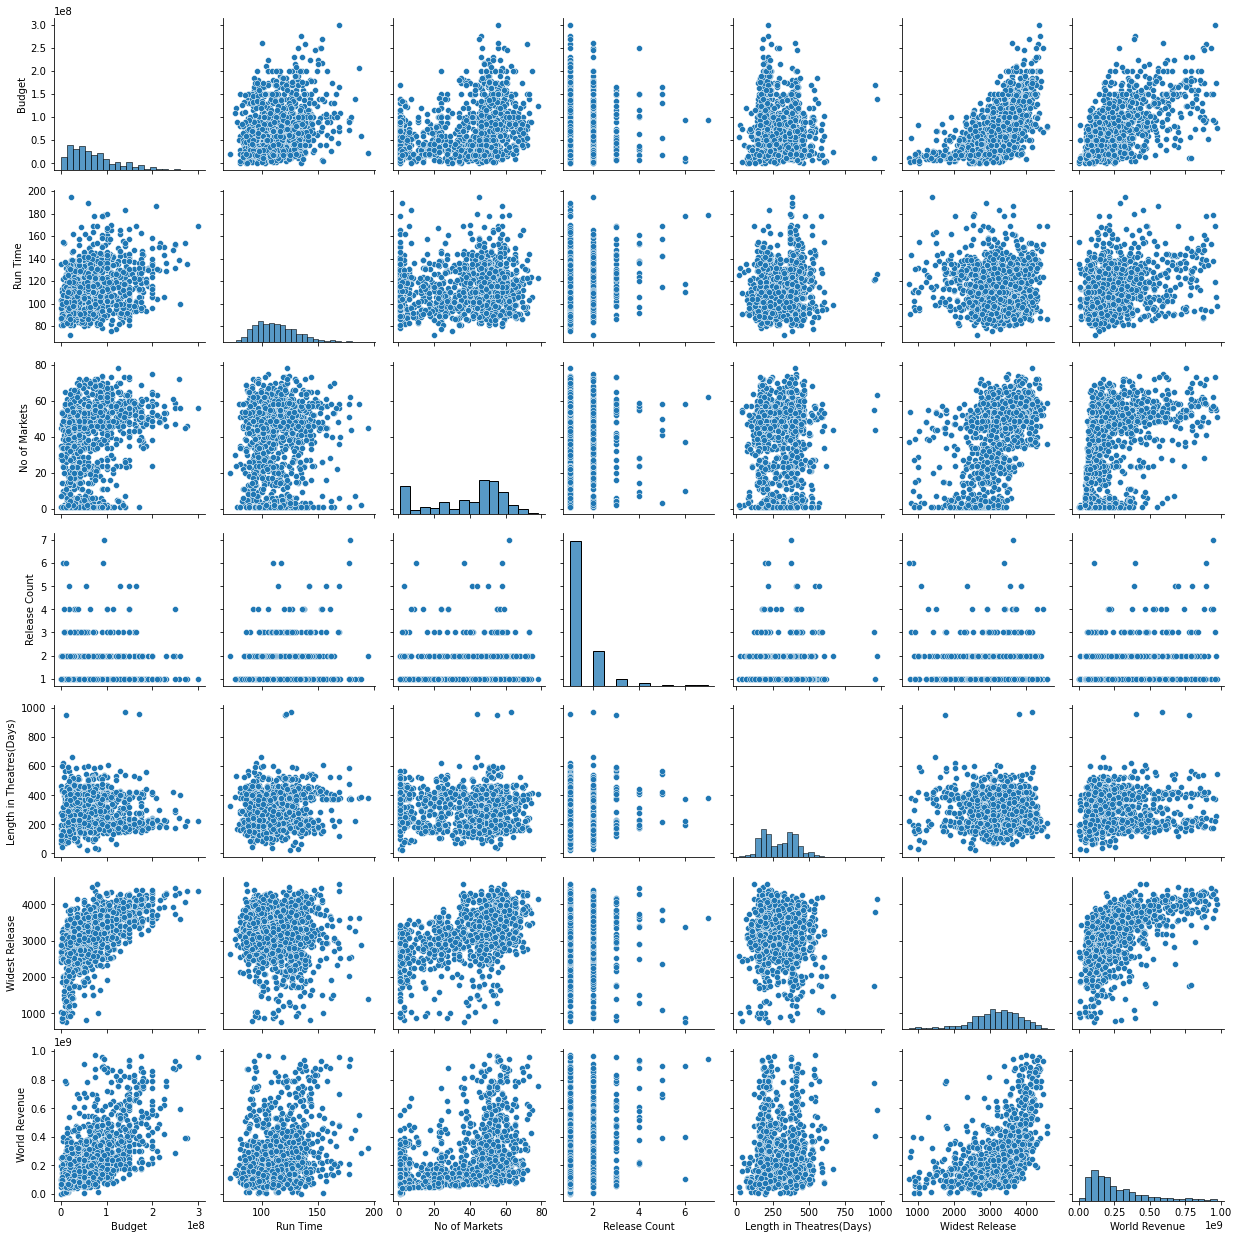

In [26]:
sns.pairplot(df)

<AxesSubplot:>

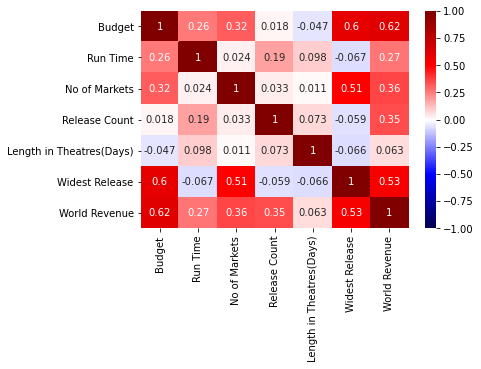

In [27]:
sns.heatmap(df.corr(), cmap="seismic", annot=True, vmin=-1, vmax=1)

In [28]:
pd.get_dummies(df["Movie Rating"])

,G,PG,PG-13,R
18,0,1,0,0
21,0,1,0,0
22,0,1,0,0
25,0,0,1,0
30,0,0,1,0
...,...,...,...,...
987,0,0,0,1
993,0,0,0,1
996,0,0,1,0
997,0,1,0,0


In [29]:
def split_and_validate(X, y):
    '''
    For a set of features and target X, y, perform a 80/20 train/val split, 
    fit and validate a linear regression model, and report results
    '''
    
    # perform train/val split
    X_train, X_val, y_train, y_val = \
        train_test_split(X, y, test_size=0.2, random_state=42)
    
    # fit linear regression to training data
    lr_model = LinearRegression()
    lr_model.fit(X_train, y_train)
    
    # score fit model on validation data
    val_score = lr_model.score(X_val, y_val)
    
    # report results
    print('\nValidation R^2 score was:', val_score)
    print('Feature coefficient results: \n')
    for feature, coef in zip(X.columns, lr_model.coef_):
        print(feature, ':', f'{coef:.2f}')

In [30]:
#split_and_validate(X_base,Y_base)

In [31]:
X2 = X_base.copy()

X2['WR**2'] = X2['Widest Release'] ** 2
X2['NOM**2'] = X2['No of Markets'] ** 2

split_and_validate(X2, Y_base)


Validation R^2 score was: 0.652870082140051
Feature coefficient results: 

Budget : 0.97
Run Time : 1445085.49
No of Markets : -4015757.45
Release Count : 79036167.06
Length in Theatres(Days) : 131160.40
Widest Release : -254863.34
WR**2 : 65.00
NOM**2 : 66126.99


In [32]:
X3 = X2.copy()

X3['Movie Rating'] = df['Movie Rating']

#split_and_validate(pd.get_dummies(X3, drop_first = True), Y_base)

In [33]:
lesser_prod_co = df.Production_Co.value_counts()
lesser_prod_co = list(lesser_prod_co[lesser_prod_co <30].index)
lesser_prod_co

['New Line Cinema',
 'DreamWorks',
 'DreamWorks Distribution',
 'Revolution Studios',
 'Metro-Goldwyn-Mayer (MGM)',
 'Miramax',
 'Fox Searchlight Pictures',
 'Focus Features',
 'TriStar Pictures',
 'The Weinstein Company',
 'Dimension Films',
 'Screen Gems',
 'Summit Entertainment',
 'STX Entertainment',
 'Columbia Pictures',
 'Relativity Media',
 'FilmDistrict',
 'Sony Pictures Classics',
 'Roadside Attractions',
 'Entertainment Studios Motion Pictures',
 'IFC Films',
 'Newmarket Films',
 'Open Road Films (II)',
 'A24',
 'Overture Films',
 'CBS Films',
 'Artisan Entertainment',
 'MGM/Weinstein',
 'Neon',
 '20th Century Studios',
 'Pantelion Films',
 'PolyGram',
 'USA Films',
 'Gramercy Pictures (I)',
 'Freestyle Releasing',
 'United Artists',
 'Rogue Pictures']

In [34]:
X4 = X3.copy()
X4["Production_Co"] = df["Production_Co"].replace(lesser_prod_co, "Others")

#split_and_validate(pd.get_dummies(X4, drop_first = True), Y_base)

In [35]:
seasons = df.Release_Month.value_counts()

#lesser_prod_co = list(lesser_prod_co[lesser_prod_co <5].index)

In [36]:
winter = ["December" , "November" , "January"]
spring = ["February", "March", "April"]
summer = ["May","June", "July"]
fall = ["August", "September", "October"]

In [37]:
X5 = X4.copy()

In [38]:
X5['Release_Month'] = df['Release_Month'].replace(winter, 'Winter')
X5['Release_Month'] = X5['Release_Month'].replace(spring, 'Spring')
X5['Release_Month'] = X5['Release_Month'].replace(summer, 'Summer')
X5['Release_Month'] = X5['Release_Month'].replace(fall, 'Fall')




In [39]:
#split_and_validate(pd.get_dummies(X5, drop_first = True), Y_base)


In [40]:
X6 = X5.copy()
genre = df.Genre.value_counts()
genre = list(genre[genre < 19].index)
X6["Genre"] = df["Genre"].replace(genre, "Others")


In [41]:
split_and_validate(pd.get_dummies(X6, drop_first = True), Y_base)


Validation R^2 score was: 0.6636557259416032
Feature coefficient results: 

Budget : 0.77
Run Time : 1211697.59
No of Markets : -4120237.67
Release Count : 78748131.14
Length in Theatres(Days) : 211881.17
Widest Release : -276184.26
WR**2 : 70.10
NOM**2 : 67207.47
Movie Rating_PG : 5428112.22
Movie Rating_PG-13 : 27060469.02
Movie Rating_R : 37535586.19
Production_Co_Others : -7542906.94
Production_Co_Paramount Pictures : -32677757.15
Production_Co_Sony Pictures Entertainment (SPE) : -22362709.56
Production_Co_Twentieth Century Fox : 13533691.07
Production_Co_Universal Pictures : 6843229.52
Production_Co_Walt Disney Studios Motion Pictures : 27982542.05
Production_Co_Warner Bros. : -12869403.79
Release_Month_Spring : -9660672.90
Release_Month_Summer : 48474805.55
Release_Month_Winter : 10799127.06
Genre_['Action,Adventure,Sci-Fi'] : 32612150.88
Genre_['Action,Adventure,Sci-Fi,Thriller'] : 12843595.84
Genre_['Action,Adventure,Thriller'] : 67127095.45
Genre_['Action,Crime,Thriller'] : -

<AxesSubplot:>

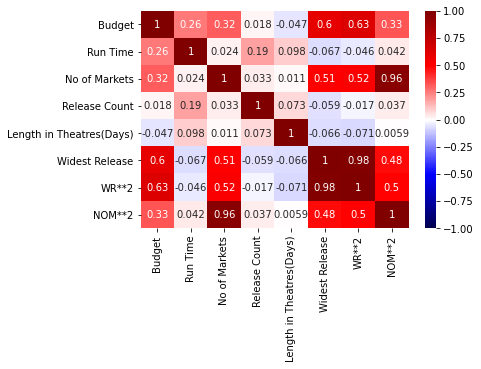

In [42]:
sns.heatmap(X6.corr(), cmap="seismic", annot=True, vmin=-1, vmax=1)



In [43]:
#X6 = df["World Revenue"]
#X6 = X6.drop(columns = "World Revenue")

In [81]:
df_with_features = df
df_with_features["WR**2"] = df["Widest Release"] **2
df_with_features["NOM**2"] = df["No of Markets"] **2

In [45]:
#plt.figure(figsize=(16,10))

#figure = sns.heatmap(df_with_features.corr(), cmap="seismic", annot=True, vmin=-1, vmax=1)

#jb_tweet_cnt.iloc[14:23,25:35]

In [82]:
df_with_features["Production_Co"] = df["Production_Co"].replace(lesser_prod_co, "Others")
#df_with_features["Production_Co"] = df["Production_Co"]
df_with_features['Release_Month'] = df['Release_Month'].replace(winter, 'Winter')
df_with_features['Release_Month'] = df_with_features['Release_Month'].replace(spring, 'Spring')
df_with_features['Release_Month'] = df_with_features['Release_Month'].replace(summer, 'Summer')
df_with_features['Release_Month'] = df_with_features['Release_Month'].replace(fall, 'Fall')

In [83]:
df_with_features = df_with_features.rename(columns={"Release_Month": "Release_Season"})

In [84]:
df_with_features["Genre"] = df["Genre"].replace(genre, "Others")
#df_with_features["Genre"] = df["Genre"]

In [85]:
#df_with_features = pd.get_dummies(df_with_features, columns=['Genre', "Release_Season", "Movie Rating"], drop_first=True)

df_with_features = pd.get_dummies(df_with_features, columns=['Genre', "Production_Co", "Release_Season", "Movie Rating"], drop_first=True)

In [86]:
df_with_features = df_with_features.drop(columns = ["Length in Theatres(Days)"])
df_with_features = df_with_features.drop(columns = ["Widest Release"])
df_with_features = df_with_features.drop(columns = ["No of Markets"])
#df_with_features = df_with_features.drop(columns = ["Production_Co"])

In [87]:
X, y = df_with_features.drop(columns = ["World Revenue", "Movie Titles"]) , df_with_features["World Revenue"]

X, X_test, y, y_test = train_test_split(X, y, test_size=.2, random_state=16)

In [88]:
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=.25, random_state=43)

In [89]:
lm = LinearRegression()

In [54]:
y_train.describe()

count    6.820000e+02
mean     2.628028e+08
std      2.009339e+08
min      6.035133e+06
25%      1.166562e+08
50%      1.974640e+08
75%      3.510086e+08
max      9.707660e+08
Name: World Revenue, dtype: float64

In [90]:
std = StandardScaler()
std.fit(X_train.values)
X_tr = std.transform(X_train.values)
X_va = std.transform(X_val.values)
X_te = std.transform(X_test.values)


In [56]:
#lasso_model = Lasso(alpha = 10000)
#lasso_model.fit(X_train ,y_train)

In [91]:
alphavec = 10**np.linspace(-2,2,47620)

lasso_model = LassoCV(alphas = alphavec, cv=5)
lasso_model.fit(X_tr, y_train)

LassoCV(alphas=array([1.00000000e-02, 1.00019344e-02, 1.00038691e-02, ...,
       9.99613240e+01, 9.99806601e+01, 1.00000000e+02]),
        cv=5)

In [92]:
lasso_model.alpha_

100.0

In [93]:
train_set_pred = lasso_model.predict(X_tr)
val_set_pred = lasso_model.predict(X_va)
test_set_pred = lasso_model.predict(X_te)

In [94]:
def mae(y_true, y_pred):
    return np.mean(np.abs(y_pred - y_true))
mae(y_test, test_set_pred)

99740041.81021418

In [95]:
rmse = mean_squared_error(y_test, test_set_pred, squared=False)
mae = mean_absolute_error(y_test, test_set_pred)

print(mae)
print(rmse)

99740041.81021419
131216693.6762284


In [96]:
print(r2_score(y_train, train_set_pred))
print(r2_score(y_val, val_set_pred))
print(r2_score(y_test, test_set_pred))

0.6114748044309252
0.6067109265126498
0.535030035439352


In [63]:
'''
zero_coef = []
for idx, num in enumerate(X.columns):
    if lasso_model.coef_[idx] == 0.0:
        zero_coef.append(X.columns[idx])
'''

'\nzero_coef = []\nfor idx, num in enumerate(X.columns):\n    if lasso_model.coef_[idx] == 0.0:\n        zero_coef.append(X.columns[idx])\n'

In [64]:
'''
for idx, item in enumerate(zero_coef):
 
    X_train = X_train.drop(columns = zero_coef[idx])
    X_val = X_val.drop(columns = zero_coef[idx])
    X_test = X_test.drop(columns = zero_coef[idx])

#X_train.drop(columns = [[zero_coef]])
'''

'\nfor idx, item in enumerate(zero_coef):\n \n    X_train = X_train.drop(columns = zero_coef[idx])\n    X_val = X_val.drop(columns = zero_coef[idx])\n    X_test = X_test.drop(columns = zero_coef[idx])\n\n#X_train.drop(columns = [[zero_coef]])\n'

In [97]:
list(zip(X_train.columns, lasso_model.coef_))

[('Budget', 54935117.63947436),
 ('Run Time', 29751344.02068484),
 ('Release Count', 61804613.23611749),
 ('WR**2', 73138068.9229829),
 ('NOM**2', 18364800.263074163),
 ("Genre_['Action,Adventure,Sci-Fi']", 15185638.88748011),
 ("Genre_['Action,Adventure,Sci-Fi,Thriller']", -1153918.1544239663),
 ("Genre_['Action,Adventure,Thriller']", 12951591.978019064),
 ("Genre_['Action,Crime,Thriller']", -5680806.180335248),
 ("Genre_['Adventure,Animation,Comedy,Family,Fantasy']", 3572642.2176804407),
 ("Genre_['Comedy']", 1639995.9901548992),
 ("Genre_['Comedy,Drama']", 1706843.1111160724),
 ("Genre_['Comedy,Drama,Romance']", 2842963.5477454653),
 ("Genre_['Comedy,Romance']", 2414259.691634874),
 ("Genre_['Horror,Mystery,Thriller']", 3640078.969789409),
 ('Production_Co_Others', 16153215.834064825),
 ('Production_Co_Paramount Pictures', 1726481.4297840905),
 ('Production_Co_Sony Pictures Entertainment (SPE)', 8215629.098499794),
 ('Production_Co_Twentieth Century Fox', 25018487.004430708),
 ('Pro

In [98]:
low_coef = []
for idx, num in enumerate(X_train.columns):
    if lasso_model.coef_[idx] <= abs(2000000):
        low_coef.append(X_train.columns[idx])

In [99]:
for idx, item in enumerate(low_coef):
 
    X_train = X_train.drop(columns = low_coef[idx])
    X_val = X_val.drop(columns = low_coef[idx])
    X_test = X_test.drop(columns = low_coef[idx])

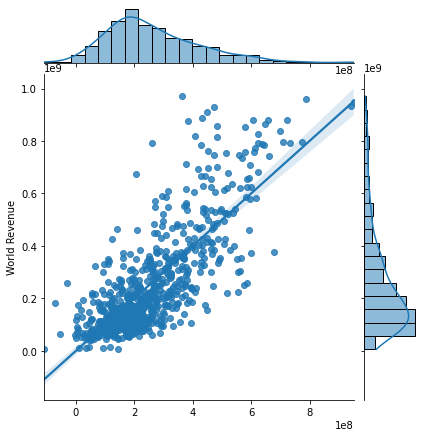

In [100]:
preds = lasso_model.predict(X_tr) # generate predictions (on training data) using fit model

sns.jointplot(x=preds,y=y_train, kind='reg')

In [ ]:
###

In [69]:
std = StandardScaler()
std.fit(X_train.values)
X_tr = std.transform(X_train.values)
alphas, _, coefs = lars_path(X_tr, y_train.values, method='lasso')

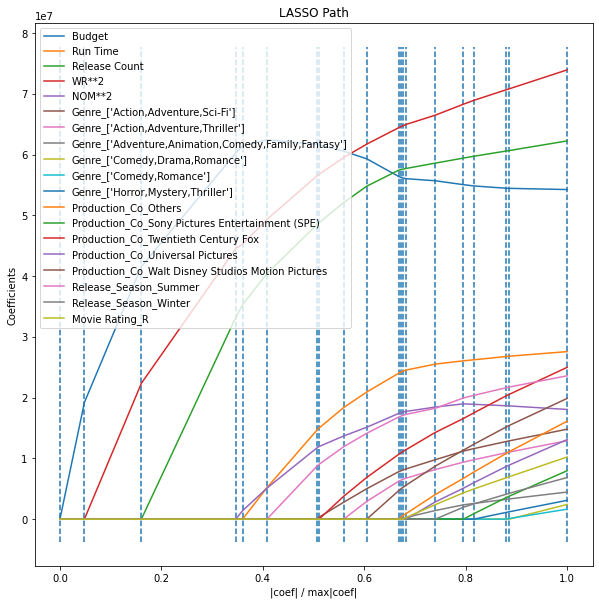

In [70]:
xx = np.sum(np.abs(coefs.T), axis=1)
xx /= xx[-1]

plt.figure(figsize=(10,10))
plt.plot(xx, coefs.T)
ymin, ymax = plt.ylim()
plt.vlines(xx, ymin, ymax, linestyle='dashed')
plt.xlabel('|coef| / max|coef|')
plt.ylabel('Coefficients')
plt.title('LASSO Path')
plt.axis('tight')
plt.legend(X_train.columns)
plt.show()

<AxesSubplot:>

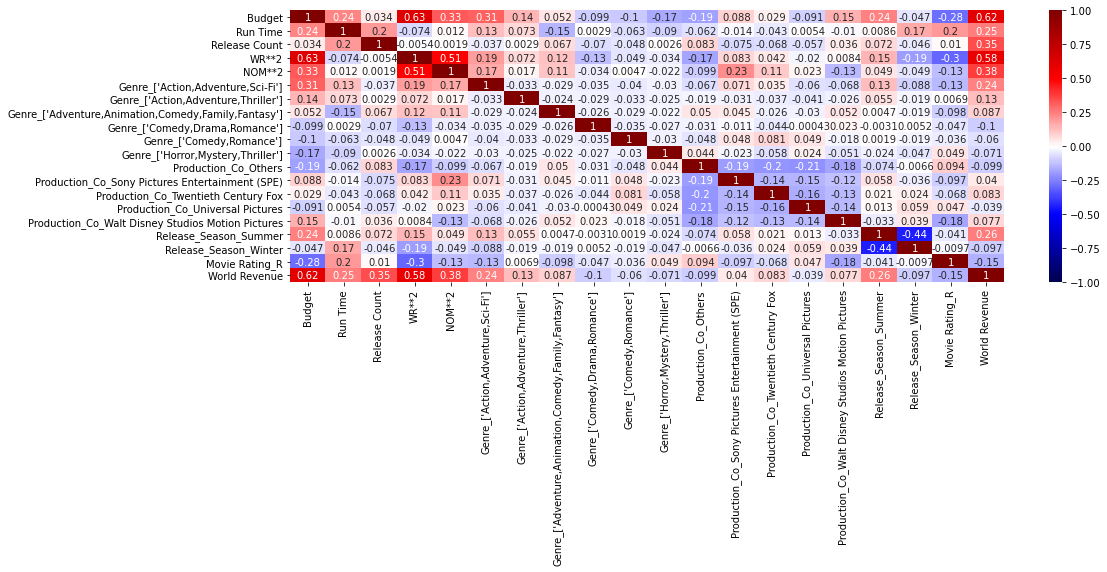

In [71]:
heat_map = X_train
heat_map["World Revenue"] = y_train
plt.figure(figsize=(16,5))
sns.heatmap(heat_map.corr(), cmap="seismic", annot=True, vmin=-1, vmax=1)

In [101]:
kf = KFold(n_splits=5, shuffle=True, random_state = 71)
cross_val_score(lm, X_tr, y_train, cv=kf, scoring='r2')

array([0.46415847, 0.53937675, 0.67726196, 0.59166417, 0.56711145])

In [103]:
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_tr)
X_test_scaled = scaler.transform(X_te)

lm_reg = Ridge(alpha=100)
lm_reg.fit(X_train_scaled,y_train)
print(f'Ridge Regression test R^2: {lm_reg.score(X_test_scaled, y_test):.3f}')

Ridge Regression test R^2: 0.544
